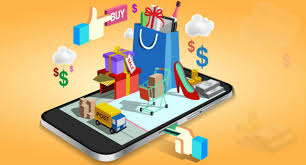

In [ ]:
#@title #Online Retail Customer Segmentation
Image('images.jpg', width = 600, height = 300, embed=True  ) 

### Information About Online Retail Data Set

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts and many customers of the company are wholesalers.
The dataset resource is [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Online+Retail)

### Data Dictionary 
**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter **'c'**, it indicates a cancellation.

**StockCode:** Product (item) code. A 5-digit integral number uniquely assigned to each distinct product. Variable type is *nominal*

**Description:** Product (item) name. Variable type is *nominal*

**Quantity:** The quantities of each product (item) per transaction. Variable type is *numeric*

**InvoiceDate:** Invoice date and time. The day and time when each transaction was generated. Variable type is *numeric*

**UnitPrice:** Unit price. Product price per unit in sterling. Variable type is *numeric*

**CustomerID:** Customer number. A 5-digit integral number uniquely assigned to each customer. Variable type is *nominal*

**Country:** Country name. The name of the country where each customer resides.
Variable type is *nominal*


In [ ]:
# importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import seaborn as sn
import datetime as dt
import sklearn as sc
import time
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [ ]:
#@title Importing the data set
# Importing the csv file
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

In [ ]:
#@title Data Set Glance
# Making a data frame from the csv file
data = pd.read_csv('OnlineRetail.csv', encoding = "ISO-8859-1")
data.head(7)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom


In [ ]:
#@title Data Set Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


We checked the dataset structure here and all the variables are aligned by the info given in the data dictionary section. However, customer ID variable type looks float, so we will turn it to string type. Before doing it, we will examine unique values and NA values in each column. 

In [ ]:
#@title Null Values In The Data Set
#Checking null values in the columns 
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

**Imputing NA Values **

One thing we thought for imputing them based on invoice number. Invoice number is unique for each
transcation. That's why it belongs to only one customer. We checked the null values whether any item in the same invoice has the customer_id. However, it didnt work. So, we decided the remove NA's since we have enough observations to apply our clustering 

In [ ]:
#@title Removing NAs and Data Frame Shape After Dropping 
newdata = data.dropna()
newdata.isnull().sum()
newdata.shape

(406829, 8)

In [ ]:
#@title Changing CustomerID and InvoiceDate Data Types
warnings.filterwarnings('ignore')
#Changing the data type
newdata['CustomerID'] = newdata['CustomerID'].astype(str)
#newdata['CustomerID'] = newdata.CustomerID.astype(int).astype(str)
#newdata['InvoiceDate'] = pd.to_datetime(newdata['InvoiceDate'],format='%d-%m-%Y %H:%M')
newdata['InvoiceDate'] = pd.to_datetime(newdata.InvoiceDate, format='%m/%d/%Y %H:%M')
newdata.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [ ]:
#@title Data Frame After Dropping Duplicate Rows
newdata = newdata.drop_duplicates()
newdata.shape

(401604, 8)

In [ ]:
#@title Total Unique Values in Each Column
newdata.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [ ]:
#@title Finding in Which Country The Business Have More Transactions
most_order = newdata.groupby('Country', as_index=False)['InvoiceDate'].count().sort_values('InvoiceDate', ascending= False)
most_order.columns = ['Country', 'Total_Transactions']

Orders from mostly England. Germany, France, Erie, Spain, and Netherlands follow England respectively. However, the dataset is mostly have Eng observations from England and we will limit our customer segmentation with England 

Text(0, 0.5, 'Country')

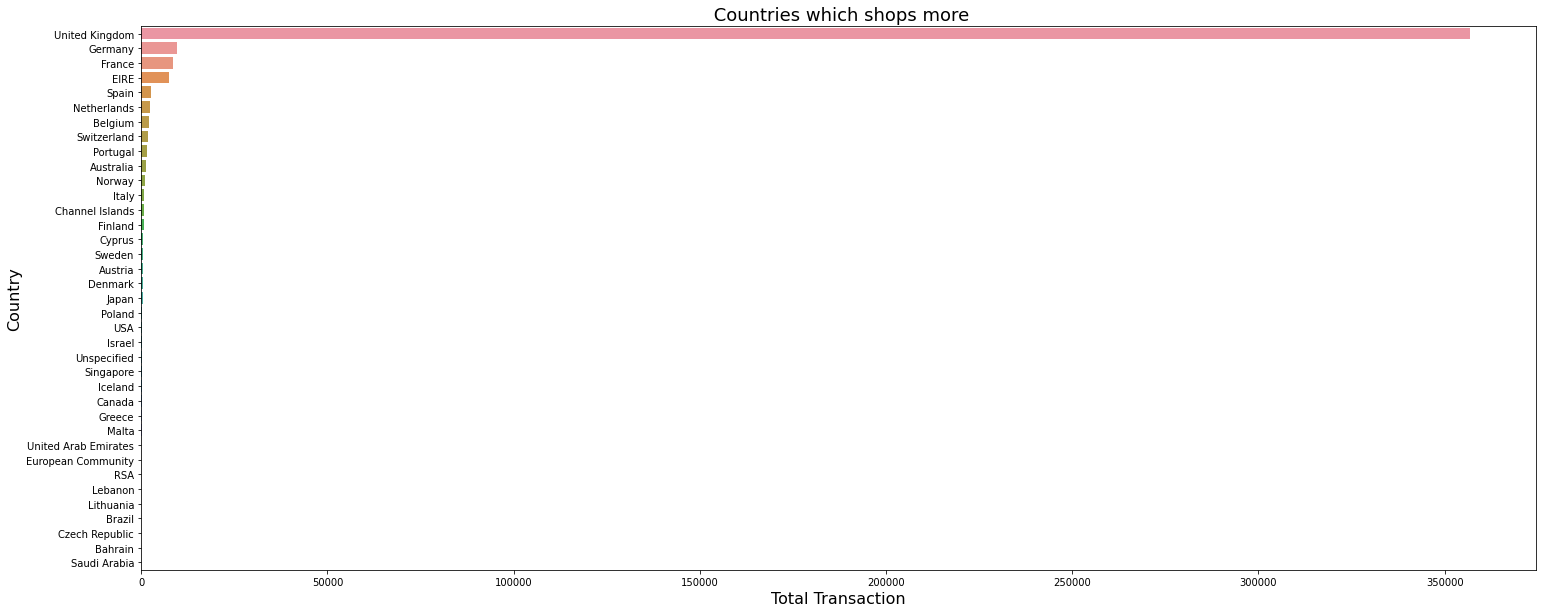

In [ ]:
#@title Countries by Total Transaction Numbers
fig = plt.figure(figsize=(25, 10))
X_axis = most_order['Total_Transactions']
Y_axis = most_order['Country']
sn.barplot(X_axis, Y_axis)
plt.title(' Countries which shops more', fontsize=18)
plt.xlabel('Total Transaction', fontsize=16)
plt.ylabel('Country', fontsize=16)

In [ ]:
#@title Creating the new data set England and Checking Statistical Values 
england = newdata.loc[newdata['Country'] == 'United Kingdom']
england.describe().round(3)

,Quantity,UnitPrice
count,356728.000,356728.000
mean,11.199,3.268
std,264.998,71.162
min,-80995.000,0.000
25%,2.000,1.250
50%,4.000,1.950
75%,12.000,3.750
max,80995.000,38970.000


Since unit price has 0 values, we will remove them. However, we will keep the minus quantities because it will help us to detect the behaviour of customers who had returns. 

In [ ]:
#@title Data Frame Shape After Elimination 0 Unit Prices
england = england[(england['UnitPrice']>0)]
england.shape

(356704, 8)

In [ ]:
#@title England Data Set Unique Values in Each Column
#Examining England Data Set
england.nunique()

InvoiceNo      19854
StockCode       3661
Description     3860
Quantity         425
InvoiceDate    18438
UnitPrice        568
CustomerID      3949
Country            1
dtype: int64

In [ ]:
#@title Number of Items in Each Invoice
totalitem = england.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
totalitem.columns = ['CustomerID', 'InvoiceNo', 'item_ea']
totalitem.sort_values('item_ea')

,CustomerID,InvoiceNo,item_ea
0,12346.0,541431,1
11524,15922.0,C536737,1
11521,15920.0,559511,1
11488,15906.0,C548155,1
11479,15903.0,C545847,1
...,...,...,...
4972,14096.0,573576,435
4975,14096.0,578270,442
4977,14096.0,580727,529
4976,14096.0,579196,533


This table shows that customer profile changes based on their shopping behaviour. Some customers buy frequentl with less quantities and some of them buy frequently with big amounts, and some of them shop rarely with big quantities. 

In [ ]:
#@title Adding New Variable Total Price 
#Add a new variable total price
england['TotalPrice'] = england['Quantity'] * england['UnitPrice']
england.describe().round(3)

,Quantity,UnitPrice,TotalPrice
count,356704.000,356704.000,356704.000
mean,11.164,3.268,18.915
std,264.175,71.165,455.172
min,-80995.000,0.001,-168469.600
25%,2.000,1.250,3.900
50%,4.000,1.950,10.200
75%,12.000,3.750,17.700
max,80995.000,38970.000,168469.600


**CUSTOMER SEGMENTATION**

**RFM TABLE**

RFM (recency, frequency, monetary) analysis is a marketing technique used to determine quantitatively which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency),and how much the customer spends (monetary). In next steps, we will be using RFM table for our customer clustering process.

To asses how **recently** customers shopped 

*   Find the most recent date in dataset and select the next day
*   Find the oldest date in the data set
*   Find the difference between them 

It is better recency value is lower because it shows that the customer shopped recently. 

To assses **frequency** for each customer

*   We counted number of InvoiceNo for each unique customer

To assses **monetary** value of each customer

*   We found how much money brought each unique customer to the business from December 2010 to December 2011


In [ ]:
#@title Most Recent Day in Data Set 
max_date = max(england['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:49:00')

In [ ]:
#@title Oldest Day In The Data Set
X = dt.datetime(2011,12,10)
min_date = england['InvoiceDate'].min()
min_date

Timestamp('2010-12-01 08:26:00')

In [ ]:
#@title Creating Recency Column
# Compute the difference between max date and transaction date
england['recency'] = X - england['InvoiceDate']
england.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 15:34:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 15:34:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 15:34:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 15:34:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 15:34:00


In [ ]:
#@title Creating RFM Table
# Compute last transaction date to get the recency of customers
rfm_table = england.groupby('CustomerID').agg({'InvoiceDate': lambda x: (X - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()}).sort_values('CustomerID')
rfm_table.columns = ['recency','freq','monetary']
rfm_table.sort_values('monetary').head()

,recency,freq,monetary
CustomerID,,,
17448.0,144,1,-4287.63
15369.0,144,1,-1592.49
14213.0,371,5,-1192.20
17603.0,50,15,-1165.30
15823.0,337,17,-840.76


Text(0.5, 0, 'Attributes')

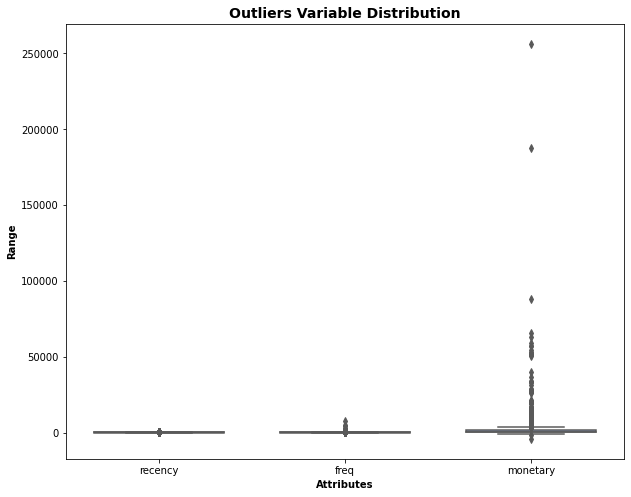

In [ ]:
#@title Box Plot for RFM Variables
attributes = ['recency','freq','monetary']
plt.rcParams['figure.figsize'] = [10,8]
sn.boxplot(data = rfm_table[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

We assessed that frequency and monetary has outliers since it will cause to have high variance and this affects some cluster algorithms such as k-means

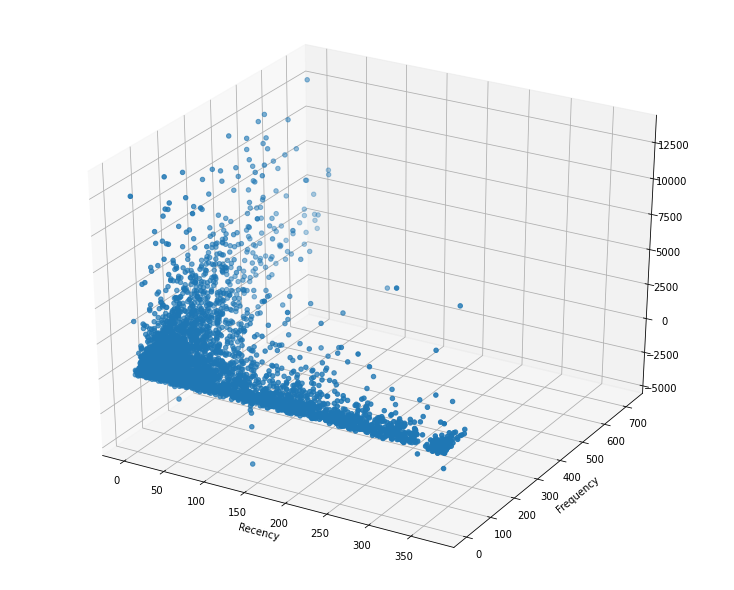

In [ ]:
#@title Removing Outliers and 3D Plot for  RFM
 # Removing (statistical) outliers for Monetary
Q1 = rfm_table.monetary.quantile(0.05)
Q3 = rfm_table.monetary.quantile(0.95)
IQR = Q3 - Q1
rfm_table = rfm_table[(rfm_table.monetary >= Q1 - 1.5*IQR) & (rfm_table.monetary <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm_table.recency.quantile(0.05)
Q3 = rfm_table.recency.quantile(0.95)
IQR = Q3 - Q1
rfm_table = rfm_table[(rfm_table.recency >= Q1 - 1.5*IQR) & (rfm_table.recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm_table.freq.quantile(0.05)
Q3 = rfm_table.freq.quantile(0.95)
IQR = Q3 - Q1
rfm_table = rfm_table[(rfm_table.freq >= Q1 - 1.5*IQR) & (rfm_table.freq <= Q3 + 1.5*IQR)]

#3d scatter plot original data points after outlier treatment
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_table['recency'], rfm_table['freq'], rfm_table['monetary'])
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

The illustration of data points after outliers are removed is shown above

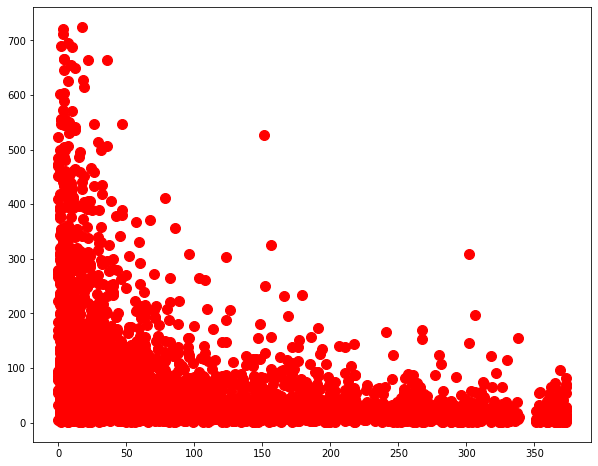

In [ ]:
#@title 2D Visualization Recency vs Frequency
plt.scatter(rfm_table['recency'], rfm_table['freq'], s = 100, c = 'red',)


We drawn 2d visualizations to understand the relationship of each variable and where the customers are gathered. Recency frequency table. Recency value increases frequency value drops. This shows us that we have some customers shopped before but they don't shop frequently

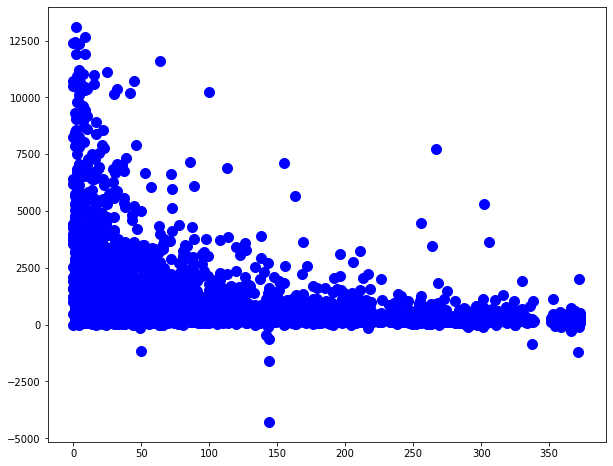

In [ ]:
#@title 2D Visualizations Recency vs Monetary
plt.scatter(rfm_table['recency'], rfm_table['monetary'], s = 100, c = 'blue')

Most of the monetary value comes from customers that has shopped recently

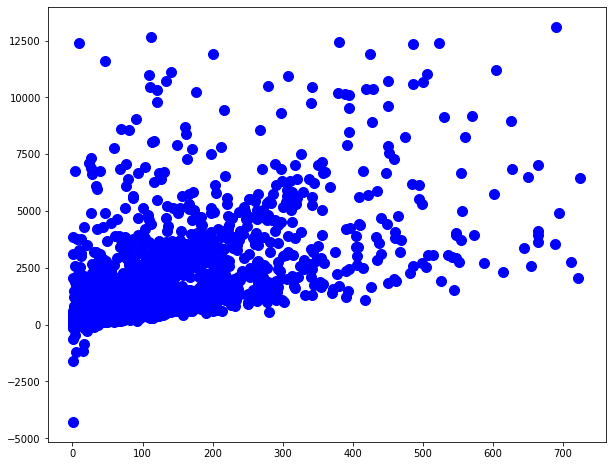

In [ ]:
#@title  2D Visualization Frequency vs Monetary 
plt.scatter(rfm_table['freq'], rfm_table['monetary'], s = 100, c = 'blue')

Most customers shopped between 100-300 times and monetary value of each of them are about up to 5000$.

Text(0, 0.5, 'Frequency')

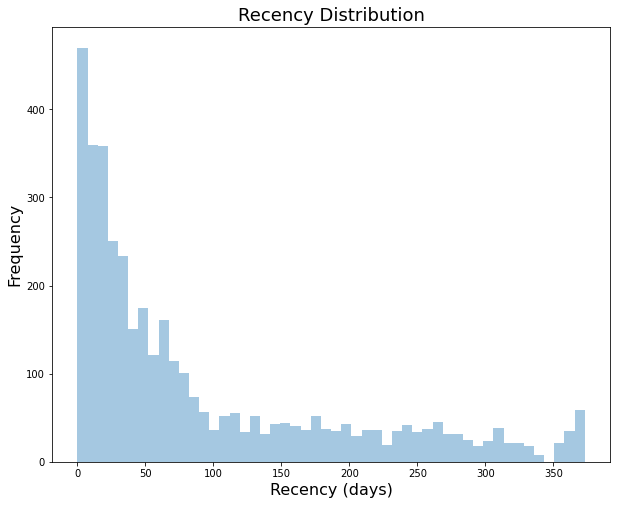

In [ ]:
#@title Recency Distribution
sn.distplot(rfm_table['recency'], kde=False, bins = 50)
plt.title('Recency Distribution', fontsize=18)
plt.xlabel('Recency (days)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)


Text(0, 0.5, 'Frequency')

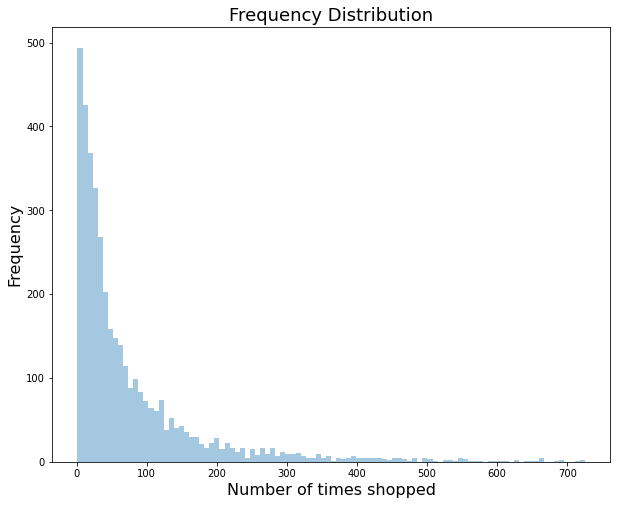

In [ ]:
#@title Frequency Distribution
sn.distplot(rfm_table['freq'], kde=False, bins = 100)
plt.title('Frequency Distribution', fontsize=18)
plt.xlabel('Number of times shopped', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

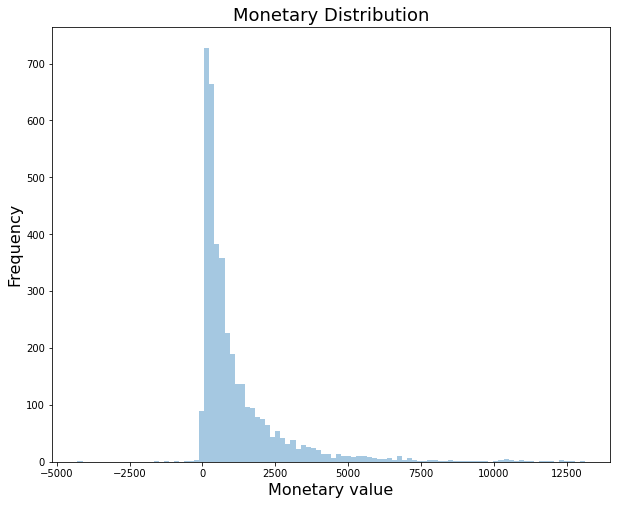

In [ ]:
#@title Monetary Distribution
sn.distplot(rfm_table['monetary'], kde=False, bins = 100)
plt.title('Monetary Distribution', fontsize=18)
plt.xlabel('Monetary value', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

We drew the distribution of rfm table variables to assess what kind of data set we are working on it. Our data set is highly right skewed.

In [ ]:
#@title RFM Table Statistical Values
rfm_table.describe().round(3)

,recency,freq,monetary
count,3881.000,3881.000,3881.000
mean,92.774,76.357,1202.261
std,100.455,99.924,1654.400
min,0.000,1.000,-4287.630
25%,17.000,16.000,275.400
50%,50.000,39.000,609.300
75%,147.000,95.000,1431.780
max,373.000,725.000,13110.020


After checking the statistical values, we apply scaling because
rescaling atttributes are extremely important. So,they can have a comparable scale. 
There are two common ways of rescaling:

* Min-Max scaling
* Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [ ]:
#@title Applying Standardization 
# Rescaling the attributes
rfm_df = rfm_table[['recency', 'freq', 'monetary']]
# Instantiate
scaler = StandardScaler()
# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape
# Converting normalized rfm_df_scaled array to data frame 
rfm_scaled_dfr = pd.DataFrame({'recency': rfm_df_scaled[:, 0], 'freq': rfm_df_scaled[:, 1], 'monetary': rfm_df_scaled[:, 1] })
rfm_scaled_dfr.head()



,recency,freq,monetary
0,2.312049,-0.744230,-0.744230
1,-0.903749,0.266665,0.266665
2,-0.893793,1.547799,1.547799
3,-0.893793,-0.173725,-0.173725
4,1.206929,-0.704195,-0.704195


# **Hierarchical Clustering**
Hierarchical Clustering helps us to create nested clusters organized as a hierarchical tree. One of the advantage of the hierarchical clustering, we dont have to guess cluster numbers. Cluster numbers can be deduced from the dendogram
which is a tree diagram shows sequential merges or splits. In our project we used agglomerative hierarchical cluster algorithm. Agglomerative apprach takes every single point as a cluster and then merge them based on their similarity. 
During this merge, we used euclidian distance. Also, we try different methods to select the distance between each cluster before merging to illustrate how selecting different methods can change our dendogram. Methods we tried for intercluster distance are wards, complete, and average


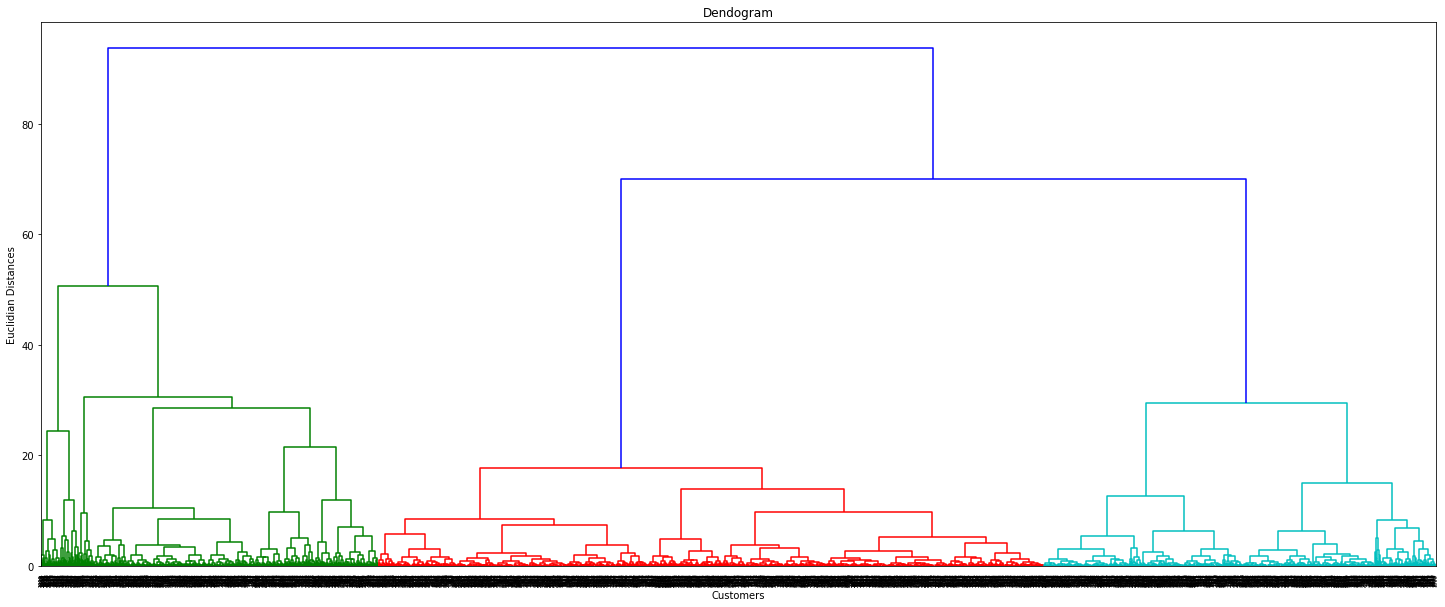

In [ ]:
#@title Dendogram-Ward Method
#If we select ward method to inter cluster distance selection
start_time_dn = time.time()
fig = plt.figure(figsize=(25, 10))
dendogram = sch.dendrogram(sch.linkage(rfm_df_scaled, method = 'ward'))
plt.title("Dendogram")
plt.xlabel("Customers")
plt.ylabel("Euclidian Distances")
plt.show()

In [ ]:
#@title Dendogram Execution Time
time_taken_dn = time.time() - start_time_dn
print(time_taken_dn)

86.81555414199829


Wards method uses the increase of squared error between two clusters when they are merged.

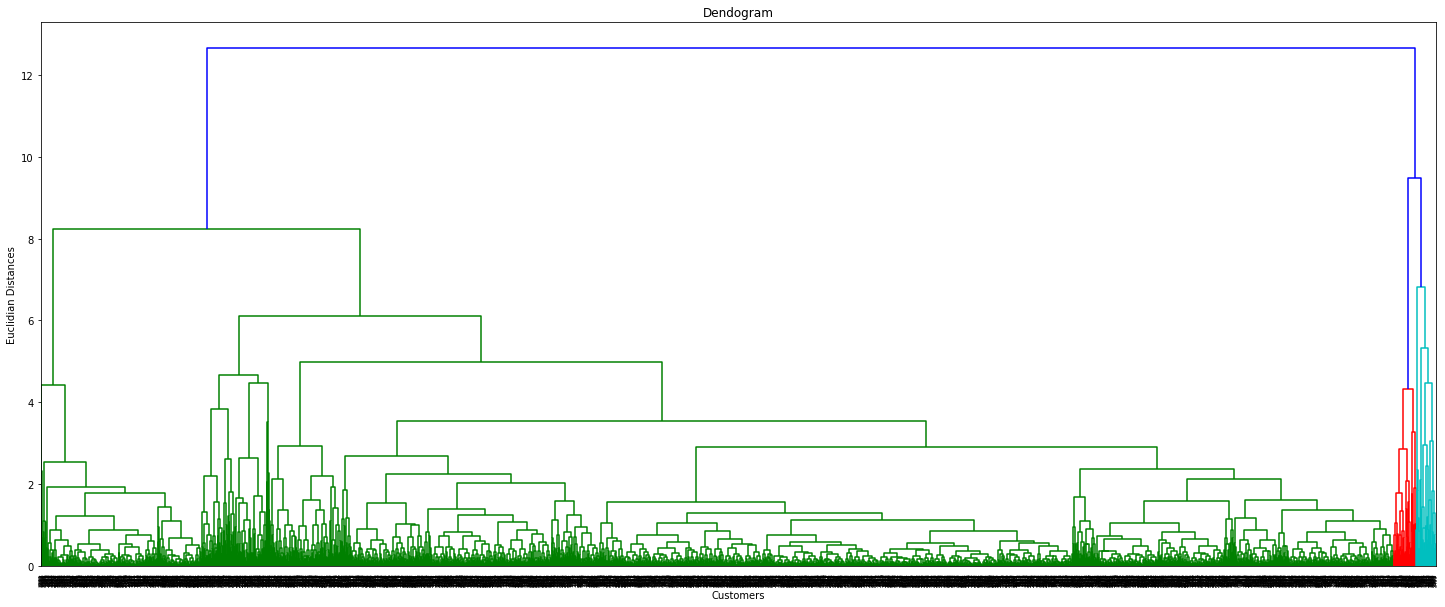

In [ ]:
#@title Dendogram-Complete Link
#If we select to inter cluster distance as max
fig = plt.figure(figsize=(25, 10))
dendogram_max = sch.dendrogram(sch.linkage(rfm_df_scaled, method = 'complete'))
plt.title("Dendogram")
plt.xlabel("Customers")
plt.ylabel("Euclidian Distances")
plt.show()

Complete link uses maximum distance between two data points and creates clusters based on maximum distance. For instance if we have two data points in a cluster and measuring the distance to other data point out of the cluster. Complete link measures the distance from both two points in the cluster. Selects the maximum distance to updata proximity matrix.

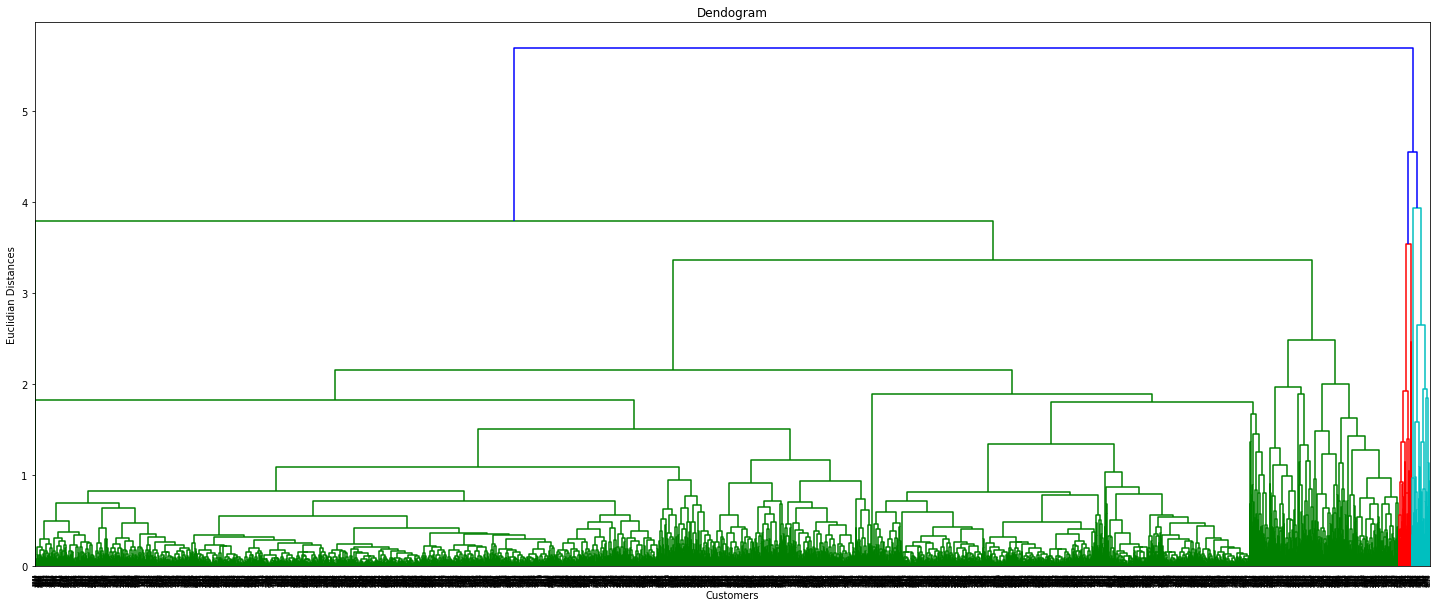

In [ ]:
#@title Dendogram Average Link
fig = plt.figure(figsize=(25, 10))
dendogram_average = sch.dendrogram(sch.linkage(rfm_df_scaled, method = 'average'))
plt.title("Dendogram")
plt.xlabel("Customers")
plt.ylabel("Euclidian Distances")
plt.show()

Average link uses the average distance between interclusters. The proximity of two clusters is defined as the average pairwise proximity among all pairs of points in the different clusters 

In [ ]:
#@title Applying Algorithm to Data Set and Assessing Execution Time
start_time_hc = time.time()
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(rfm_df_scaled)
time_taken_hc = time.time() - start_time_hc
print(time_taken_hc)

0.4526524543762207


Among these inter cluster distance methods, we select the ward methods since it merges clusters based on increase of squared error and it creates more clear dendogram for our dataset. Execution time for hierarchical clustering is 0.44. For drawing the dendogram 97.07

            recency  freq  monetary  Label
CustomerID                                
12346.0         325     2      0.00      1
12747.0           2   103   4196.01      0
12749.0           3   231   3868.20      0
12820.0           3    59    942.34      2
12821.0         214     6     92.72      1
...             ...   ...       ...    ...
18280.0         277    10    180.60      1
18281.0         180     7     80.82      1
18282.0           7    13    176.60      2
18283.0           3   721   2045.53      0
18287.0          42    70   1837.28      0

[3881 rows x 4 columns]


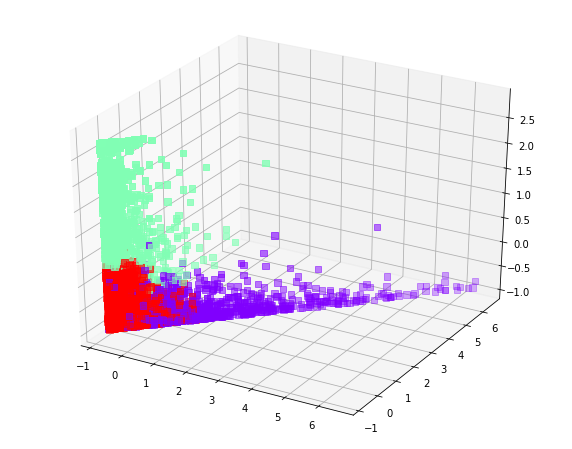

In [ ]:
#@title Creating 3D Visualization For Clusters
rfm_labelled= rfm_table
rfm_labelled['Label'] = y_hc
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(rfm_df_scaled_labelled['monetary'])
y = np.array(rfm_df_scaled_labelled['freq'])
z = np.array(rfm_df_scaled_labelled['recency'])
print (rfm_labelled)
ax.scatter(x,y,z, marker="s", c=rfm_df_scaled_labelled["Label"], s=40, cmap="rainbow")

# Silhouette Average
The silhouette value is a measure of how similar an object is to its own cluster -cohesion- compared to other clusters -separation. It can take a value 
-1<= s <=1. It is better to have a silhouette score closer to 1. Also, if silhouette score is negative, it means that points in the cluster is closer to other points to out of the cluster data points. This is a sign for misclassified data points in a cluster. In our comparison, we will be using silhouette score  since it uses both cohesion and separation

In [ ]:
#@title Silhouette Average Ward Method
silhouette_avg = silhouette_score(rfm_df_scaled, y_hc)
print("For 3 cluster, The average silhouette_score is :", silhouette_avg)

For 3 cluster, The average silhouette_score is : 0.43244931453273894


In [ ]:
#@title Max and Min Silhouette Coeeficients for Samples
#Calculated silhouette score for each observation
sample_silhouette_values = silhouette_samples(rfm_df_scaled, y_hc)
print ("Max silhouette_score is :", sample_silhouette_values.max(),
       'Min silhouette_score is :', sample_silhouette_values.min())


Max silhouette_score is : 0.7674892494064572 Min silhouette_score is : -0.6155073922212123


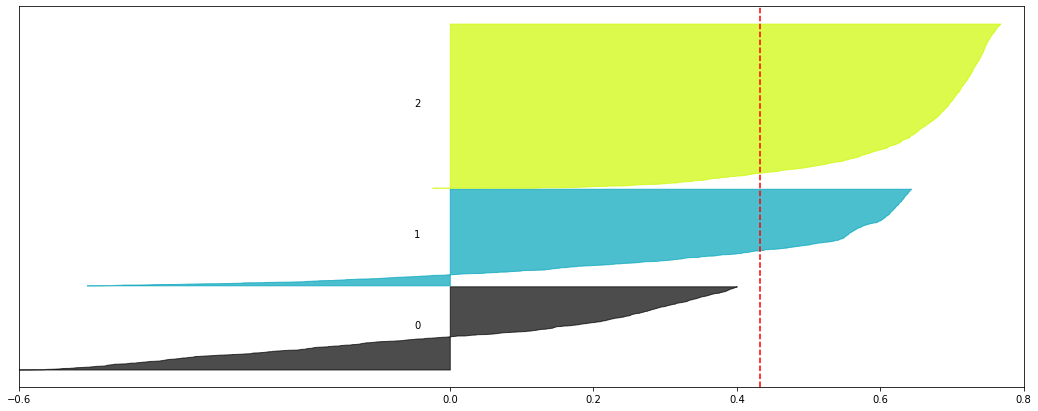

In [ ]:
#@title Visualizing Silhouette Coefficient for Clusters 
from matplotlib import cm
range_n_clusters = [3]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.6, 0.8])
    

y_lower = 10
for i in range (n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_hc == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.6, 0, 0.2, 0.4, 0.6, 0.8])




Silhouette coefficients are displayed for each cluster and it shows that some data points are not belong to in its own cluster, cluster 0 and cluster 1. Red dotted line shows the clustering average silhouette coefficient. Also, min and max silhouette coefficients are given above the graph.

# K-means Clustering
---

K-means is a simple and popular unsupervised learning algorithm which aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.


```
# Here is the k-means algorithm:
randomly chose k examples as initial centroids
while true:
  create k clusters by assigning each example to closest centroid
  conpute k new centroids by averaging examples in each cluster
  if centroids don't change:
    break

```

**The Elbow Method** is
a fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

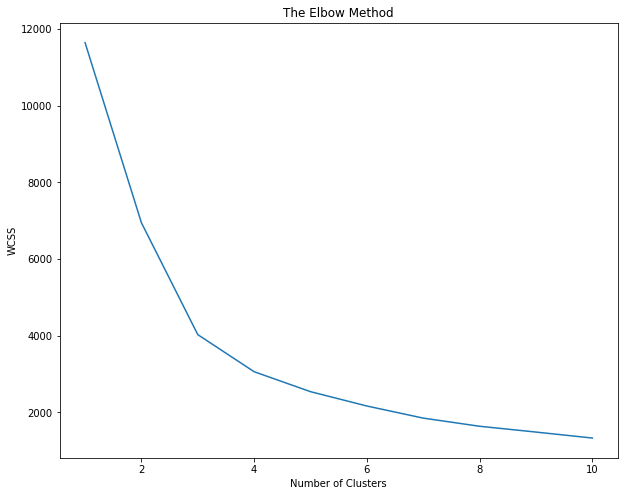

In [ ]:
#@title Assessing Optimal Number of Clusters with WCSS
#Kmeans
#Using The Elbow Method to Find Optimal Numbers of Clusters
from sklearn.cluster import KMeans
wcss = []
for i in range (1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(rfm_df_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

From the above visualization, we can see that the optimal number of clusters should be around 3. But visualizing the data alone cannot always give the right answer. Hence we demonstrate the following steps.

We now define the following:-

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
Inertia: It is the sum of squared distances of samples to their closest cluster center. We iterate the values of k from 1 to 9 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.

1 : 1.3970020872539732
2 : 1.143723406421861
3 : 0.816860599485293
4 : 0.7098354215635244
5 : 0.6730114941614794
6 : 0.6041825749755191
7 : 0.5712731703088505
8 : 0.542537789728387
9 : 0.512934642929958


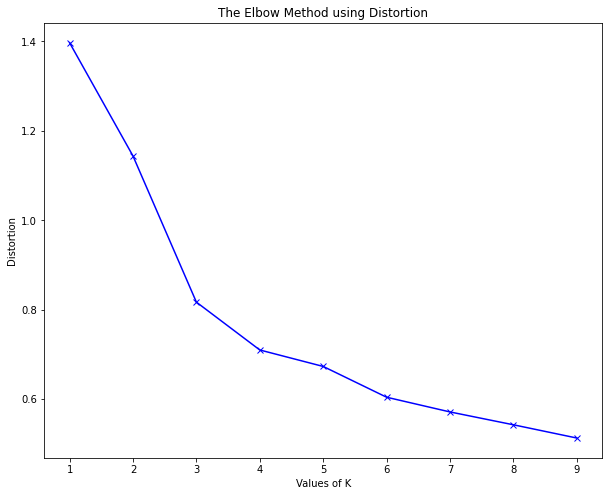

In [ ]:
#@title Using The Different Values of Distortion

from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

for k in K: 
	#Building and fitting the model 
	kmeanModel = KMeans(n_clusters=k).fit(rfm_df_scaled) 
	kmeanModel.fit(rfm_df_scaled)	 
	
	distortions.append(sum(np.min(cdist(rfm_df_scaled, kmeanModel.cluster_centers_, 
					'euclidean'),axis=1)) / rfm_df_scaled.shape[0]) 
	inertias.append(kmeanModel.inertia_) 

	mapping1[k] = sum(np.min(cdist(rfm_df_scaled, kmeanModel.cluster_centers_, 
				'euclidean'),axis=1)) / rfm_df_scaled.shape[0] 
	mapping2[k] = kmeanModel.inertia_ 


# Tabulating the results
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

# Visualizing the results
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

1 : 11642.999999999998
2 : 6944.839618253622
3 : 4026.3768696899597
4 : 3059.0897140174843
5 : 2538.440583452454
6 : 2164.228838921025
7 : 1848.2840961847346
8 : 1636.2415871137214
9 : 1484.341488133542


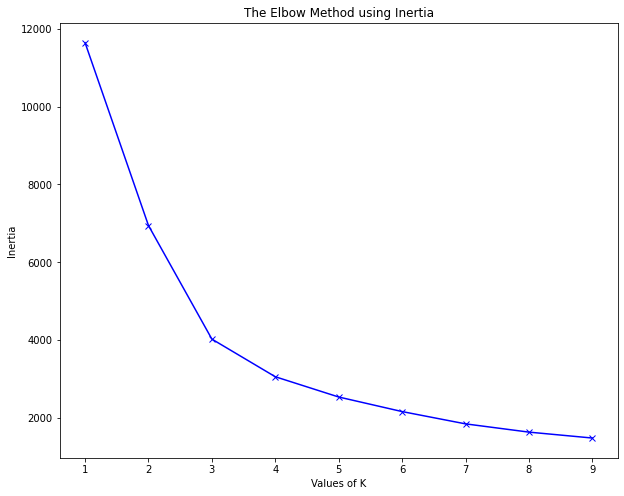

In [ ]:
#@title Using the different values of Inertia
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [ ]:
#@title Silhouette analysis
range_n_clusters_1 = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters_1:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5432601251196262
For n_clusters=3, the silhouette score is 0.5070822546535665
For n_clusters=4, the silhouette score is 0.47773237545286334
For n_clusters=5, the silhouette score is 0.46581780735795836
For n_clusters=6, the silhouette score is 0.41965307377521205
For n_clusters=7, the silhouette score is 0.41923861398042195
For n_clusters=8, the silhouette score is 0.40388067379538645


In [ ]:
#@title Applying K-Means and Assessing Execution Time
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
start_time = time.time()
y_kmeans = kmeans.fit_predict(rfm_df_scaled)
time_taken = time.time() - start_time
print(time_taken)

0.10141634941101074


In [ ]:
#@title Labelled RFM Table glance
rfm_scaled_dfr = pd.DataFrame({'recency': rfm_df_scaled[:, 0], 'freq': rfm_df_scaled[:, 1], 'monetary': rfm_df_scaled[:, 1] })
# assign the label
rfm_table['Cluster_Id'] = y_kmeans
rfm_table.head()

,recency,freq,monetary,Label,Cluster_Id
CustomerID,,,,,
12346.0,325,2,0.00,1,1
12747.0,2,103,4196.01,0,2
12749.0,3,231,3868.20,0,2
12820.0,3,59,942.34,2,0
12821.0,214,6,92.72,1,1


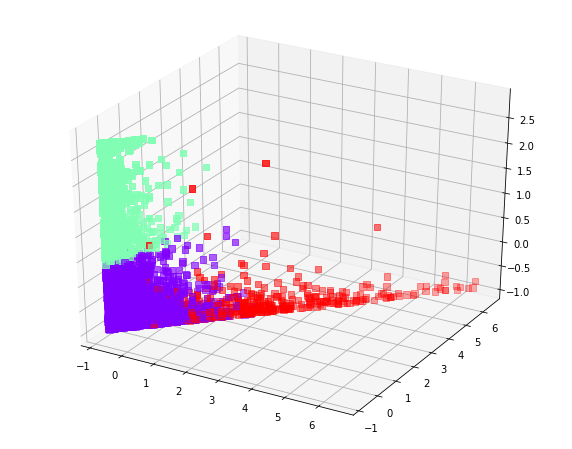

In [ ]:
#@title Visualizing K-Mean Clusters
   rfm_df_scaled_labelled_km= rfm_scaled_dfr
   rfm_df_scaled_labelled_km['Label'] = y_kmeans
   fig = plt.figure()
   ax = fig.add_subplot(111, projection='3d')
   x = np.array(rfm_df_scaled_labelled['monetary'])
   y = np.array(rfm_df_scaled_labelled['freq'])
   z = np.array(rfm_df_scaled_labelled['recency'])
   ax.scatter(x,y,z, marker="s", c=rfm_df_scaled_labelled_km["Label"], s=40, cmap="rainbow")

In [ ]:
#@title Min and Max Silhouette Coefficient for Samples
sample_silhouette_values_kmeans = silhouette_samples(rfm_df_scaled, y_kmeans)
print ("Max silhouette_score is :", sample_silhouette_values_kmeans.max(),
       'Min silhouette_score is :', sample_silhouette_values_kmeans.min())

Max silhouette_score is : 0.7056727439572875 Min silhouette_score is : -0.2042927499540083


In [ ]:
#@title Average Silhouette Value for K-Means Clustering
silhouette_avg_kmeans = silhouette_score(rfm_df_scaled, y_kmeans)
print("For 3 cluster, The average silhouette_score is :", silhouette_avg_kmeans)

For 3 cluster, The average silhouette_score is : 0.5070822546535665


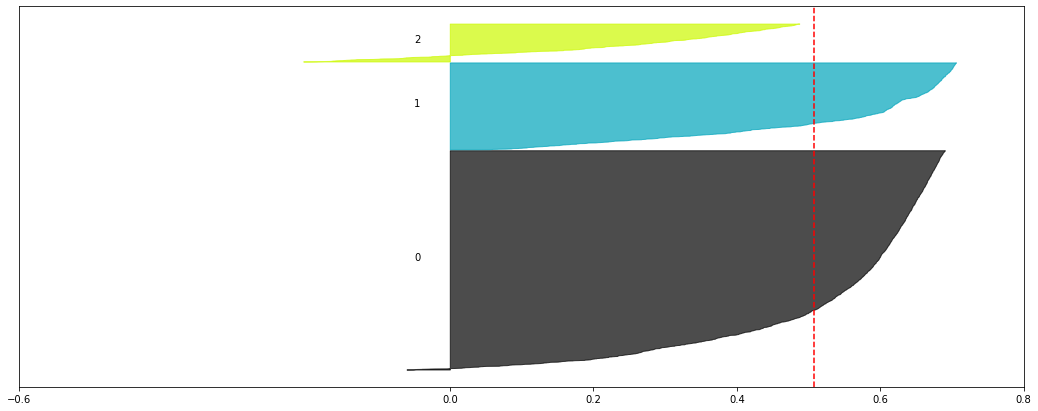

In [ ]:
#@title Silhouette Graph for K-Means Clusters 
from matplotlib import cm
range_n_clusters = [3]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.6, 0.8])
    

y_lower = 10
for i in range (n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values_kmeans[y_kmeans == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg_kmeans, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.6, 0, 0.2, 0.4, 0.6, 0.8])


As opposed to hierarchical clusterings silhouette coeeficient, k-means silhouette score has less minus values and average silhoette coefficient is 0.507 while hierarchical one is 0.432

# DBSCAN (Density-based spatial clustering of applications with noise)

DBSCAN is a clustering method that is used in machine learning to separate clusters of high density from clusters of low density.



**DBSCAN (Density-based spatial clustering of applications with noise)**

DBSCAN is a clustering method that is used in machine learning to separate clusters of high density from clusters of low density.

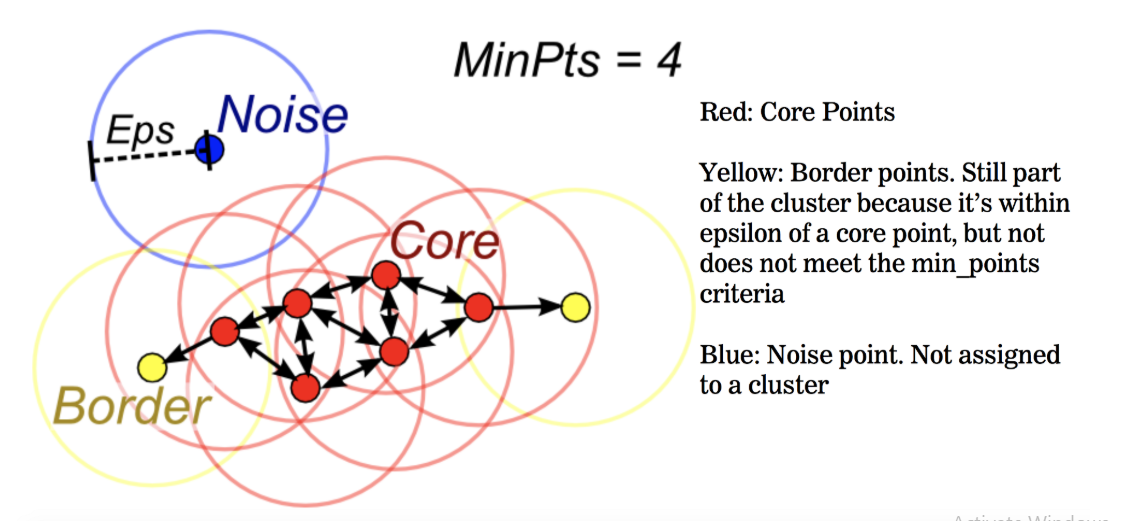


Instantiating our DBSCAN Model. In the code below, epsilon = 0.5 and min_samples is the minimum number of points needed to constitute a cluster which is 5 in our case.

In [ ]:
#@title Applying DBSCAN and Assessing Execution Time
 rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
 rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
 rfm_df_scaled.head()
 dbscan = DBSCAN(eps=0.5, min_samples = 6)
 start_time = time.time()
 model= dbscan.fit(rfm_df_scaled)
 time_taken = time.time() - start_time
 print(time_taken)
 labels = model.labels_

0.13383030891418457


In [ ]:
#@title Calculating the number of clusters
 sample_cores = np.zeros_like(labels,dtype='bool')
 sample_cores[dbscan.core_sample_indices_] = True
 n_clusters = len(set(labels))-(1 if -1 in labels else 0)
 print(n_clusters)


3


In [ ]:
#@title Silhouette For DBSCAN
print(silhouette_score(rfm_df_scaled,labels))


0.49910181738000875


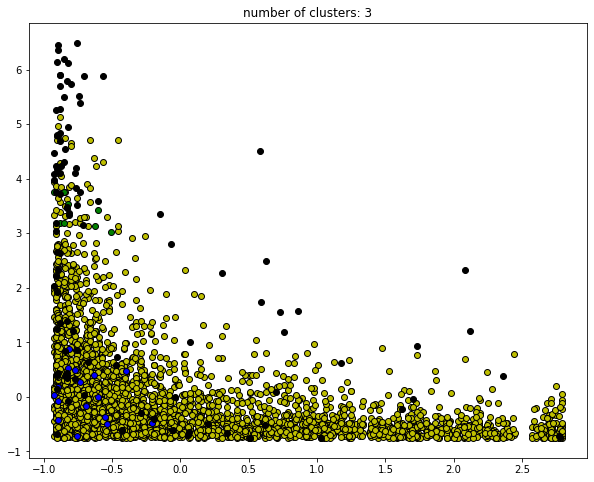

In [ ]:
#@title Amount vs Frequency DBSCAN Clusters 
unique_labels = set(labels)
colors = ['y', 'b', 'g', 'r', 'c', 'm' ] 
for k, col in zip(unique_labels, colors): 
    if k == -1: 
        # Black used for noise. 
        col = 'k'
    class_member_mask = (labels == k) 
  
    xy = rfm_df_scaled[class_member_mask & sample_cores] 
    plt.plot(xy['Amount'], xy['Frequency'], 'o', markerfacecolor=col, 
                                      markeredgecolor='k',  
                                      markersize=6) 
  
    xy = rfm_df_scaled[class_member_mask & ~sample_cores] 
    plt.plot(xy['Amount'], xy['Frequency'], 'o', markerfacecolor=col, 
                                      markeredgecolor='k', 
                                      markersize=6) 
  
plt.title('number of clusters: %d' %3) 
plt.show() 

The graph shows three clusters that are produced by DBSCAN. Also, black points are noise points in our dataset

        Amount  Frequency   Recency  Label
0     2.312049  -0.744230 -0.726798      0
1    -0.903749   0.266665  1.809801      0
2    -0.893793   1.547799  1.611631      0
3    -0.893793  -0.173725 -0.157129      0
4     1.206929  -0.704195 -0.670747      0
...        ...        ...       ...    ...
3876  1.834159  -0.664159 -0.617621      0
3877  0.868424  -0.694186 -0.677941      0
3878 -0.853969  -0.634133 -0.620039      0
3879 -0.893793   6.452142  0.509779     -1
3880 -0.505508  -0.063628  0.383886      0

[3881 rows x 4 columns]


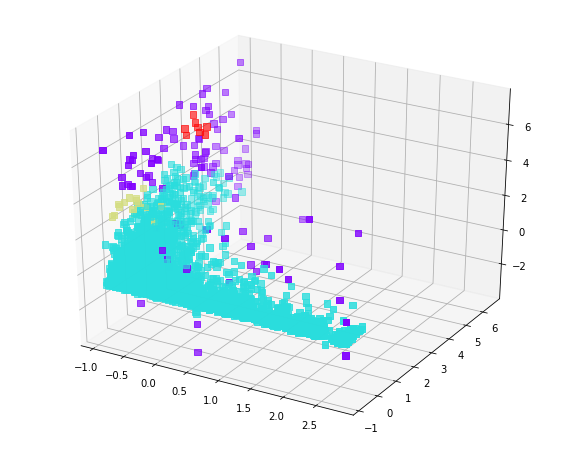

In [ ]:
#@title 3D Visualization of DBSCAN Clusters
   rfm_df_scaled_labelled= rfm_df_scaled 
   rfm_df_scaled_labelled['Label'] = labels
   fig = plt.figure()
   ax = fig.add_subplot(111, projection='3d')
   x = np.array(rfm_df_scaled_labelled['Amount'])
   y = np.array(rfm_df_scaled_labelled['Frequency'])
   z = np.array(rfm_df_scaled_labelled['Recency'])
   ax.scatter(x,y,z, marker="s", c=rfm_df_scaled_labelled['Label'], s=40, cmap="rainbow")
   print(rfm_df_scaled_labelled)

In [ ]:
#@title Cluster Similarity between k-means and hierarchical clustering
sklearn.metrics.adjusted_rand_score(y_hc, y_kmeans)

0.5873008913221868

In [ ]:
#@title Cluster Similarity between k-means and dbscan
sklearn.metrics.adjusted_rand_score(y_kmeans, labels)

0.08712894663473071

In [ ]:
#@title Cluster Similarity between hierarchical and dbscan
#
sklearn.metrics.adjusted_rand_score(y_hc, labels)

0.027666997528601227

# Conclusion

1. DBScan: DBScan is great for separating high density clusters from low density clusters But, it d
with clusters of varying densities which is our case.

2. K-means: K Means is good at handling big datasets with minimum computational time. K-mean
problems like market segmentation by e-commerce where cut-throat competition is to acquire a
customer

3. Hierarchical: Hierarchical clustering handle small datasets and with large datasets, computatio
The adjusted random score gives the value of similarity. This adjusted random score between K
hierarchical clustering is around 96%. K-means and DBScan is 3% and Hierarchical and DBScan
have different output for DBScan because it struggles with clusters of similar densities which is
dataset. Considering all the points, K-means is the Champion in our case

In [ ]:
!pip install nbconvert 

In [ ]:
!jupyter nbconvert --to html online.ipynb


[NbConvertApp] Converting notebook online.ipynb to html
[NbConvertApp] Writing 1893072 bytes to online.html
